# 0. Preliminary data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Change this address to re-run the notebook locally
folder_name = '../data/kaggle_climate/'

## Cities

In [3]:
# Read the data (warning: a 500 Mb file)
df = pd.read_csv(folder_name + 'GlobalLandTemperaturesByCity.csv')

In [4]:
print(f"Total data points: {df.shape[0]}")
print(f"Total cities: {len(df.City.unique())}")
print(f"Dates: from {min(df.dt)} to {max(df.dt)}")

Total data points: 8599212
Total cities: 3448
Dates: from 1743-11-01 to 2013-09-01


In [5]:
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude'],
      dtype='object')

In [6]:
# For future analyses, let's cast a string 'dt' to a data stamp 'Date'
df['Date'] = pd.to_datetime(df.dt)

### Data coverage

Some days early on seem to be missing, but how many? Let's try to visualize it, by making a pivot table, casting it into a numpy array, and visualizing it as an image. If data coverage is very different for different cities, it may also make sense to sort it by city.

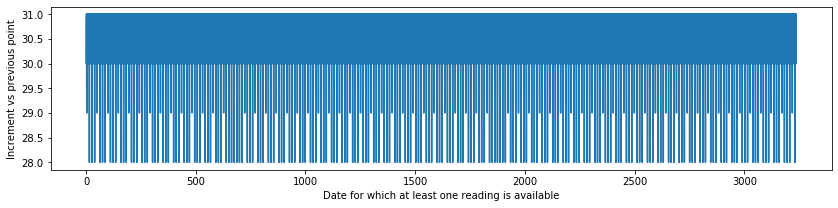

In [7]:
# What dates are even there?

days = (df.Date - df.Date.min()).dt.days.unique()   # Look at all available dates (optimistic)
days = np.sort(days)                                # Sort them
plt.figure(figsize=(14,3))
plt.plot(days[1:]-days[0:-1]);                      # Now look at jumps
plt.xlabel('Date for which at least one reading is available');
plt.ylabel('Increment vs previous point');

Conclusion: we only have months, shown as first days of every month. But that's if considering all dates that were used at least once; there's no guarantee that every city has equally good data (in fact, it is rather unprobable).

Let's try to visualize data coverage for individual cities (at least to get some idea about it). We are interested in two questions:
* differences in coverage: Are there cities with bad data?
* gaps in global coverage: Are there bad years when nobody recorded anything?

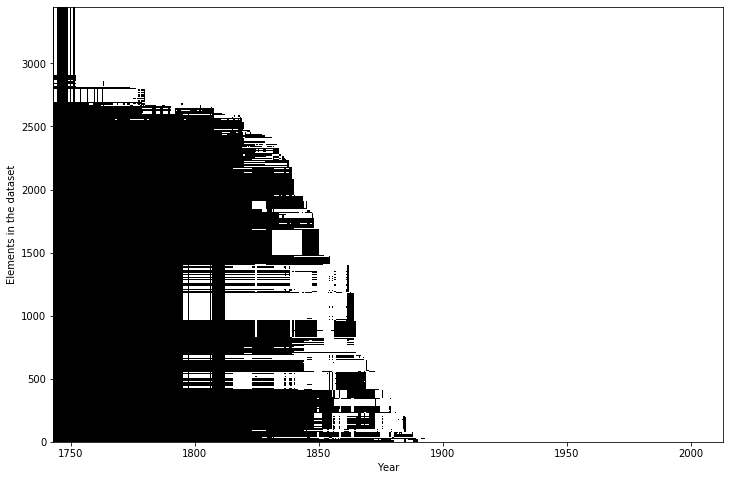

In [8]:
# Let's make a pivot, to visualize missing data
# Abstracted, to later apply same visualization to the countries dataframe

def show_availability(df, names):
    # To make sure no days are missed, let's create a fake entry with all data
    first_day = df[names[0]].min()
    last_day = df[names[0]].max()
    all_days = pd.date_range(start=first_day, end=last_day, 
                             freq=pd.offsets.MonthBegin(1)) # Generate all possible first months
    df_all_days = pd.DataFrame({names[0]: all_days})
    df_all_days[names[1]] = 'very_fake_name'
    df_all_days[names[2]] = 1  # Actual value doesn't matter    
    
    # Now drop all unnecessary columns, append fake entry, pivot, cast to numpy
    image = (df.loc[:,names]         
             .append(df_all_days)
             .pivot_table(index=names[0], columns=names[1], values=names[2])
             .drop(columns=['very_fake_name']) # This city isn't real
             .values
            )
    image[~np.isnan(image)] = 1
    image[np.isnan(image)] = 0
    image = image[:-1, :] # Cut out last month, as info for the last month is incomplete
    
    # Sort by the latest gap in coverage
    last_gap = np.zeros(image.shape[1]) # Time runs down, cities run to the right
    for i in range(image.shape[1]):        
        last_gap[i] = np.amax(np.argwhere(image[:,i]==0), initial=0)        
    ind = np.argsort(last_gap)
    
    plt.figure(figsize=(12,8))
    plt.imshow(image[:,ind].T, extent=[first_day.year, last_day.year, 0, image.shape[1]], 
               aspect='auto', cmap='gray');
    plt.xlabel('Year')
    plt.ylabel('Elements in the dataset')
    
show_availability(df, ['Date','City','AverageTemperature'])

Conclusion: it seems that data is available consistently since about 1900. Before that, it's uneven: some cities have good uninterrupted coverage since about 1770, but most joined later. And most have gaps in coverage.

It means that for variability comparisons, it may make sense to limit our analysis to 1900 and after. Same probably for predictive modeling. (Although arguably, for modeling, we could look into older data as well, if it is available... Debatable. Probably makes sense to stick to post-1900 data for all analyses, for both consistency and simplicity).

In [9]:
# It looks like 1900 is a safe date, but are there some missing values still?

def find_gaps(df, start_date, end_date):
    earliest_date = pd.to_datetime(start_date)
    latest_date = pd.to_datetime(end_date)
    out = (df
           .query("Date >= @earliest_date")
           .query("Date < @ latest_date")    
           .query("AverageTemperature.isna()", engine='python')
            )
    return out
    
find_gaps(df, '1900-01-01', '2013-01-01')

# Lovely, it looks like there are no gaps:

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Date


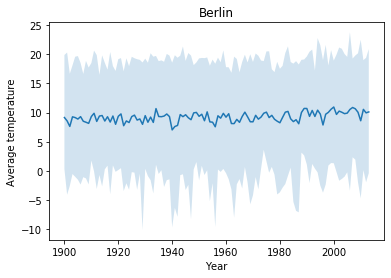

In [10]:
# Looking at some per-city trends

def cut_city(df, name, left=None, right=None):
    if left:
        left = pd.to_datetime(left)        
    else:
        left = min(df.date)
    out = (df
           .query("City == @name & Date>=@left")
           .rename({'AverageTemperature': 't'}, axis=1)
           .query('t.notna()', engine='python')
           .assign(Year = df.Date.dt.year)                        
           .groupby('Year')
           .agg({'t': ['mean', 'std', 'min', 'max']})
           .reset_index()          
          )
    out.columns = ['Year', 'Mean', 'Std', 'Min', 'Max']
    return out
    

df_city = cut_city(df, 'Berlin', '1900-01-01')
plt.fill_between(df_city.Year, df_city.Min, df_city.Max, alpha=0.2)
plt.plot(df_city.Year, df_city.Mean);
plt.xlabel('Year')
plt.ylabel('Average temperature')
plt.title('Berlin');

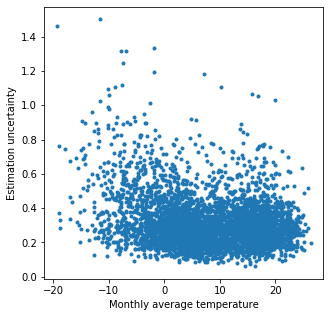

In [11]:
# How large and how different are these "Uncertainties of average temperature?" in the data

dfc = (df.
       query("City in ['Berlin', 'Moscow', 'Chicago'] & dt >= '1900-01-01'")
      )
plt.figure(figsize=(5,5))
plt.plot(dfc.AverageTemperature, dfc.AverageTemperatureUncertainty, '.');
plt.xlabel('Monthly average temperature');
plt.ylabel('Estimation uncertainty');

## Countries

Now let's do similar analyzes for the countries dataset.

In [12]:
dfc = pd.read_csv(folder_name + 'GlobalLandTemperaturesByCountry.csv')

In [13]:
dfc.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')

In [14]:
print(f"Total data points: {dfc.shape[0]}")
print(f"Total contries: {len(dfc.Country.unique())}")
print(f"Dates: from {min(dfc.dt)} to {max(dfc.dt)}")

Total data points: 577462
Total contries: 243
Dates: from 1743-11-01 to 2013-09-01


In [15]:
dfc['Date'] = pd.to_datetime(dfc.dt)

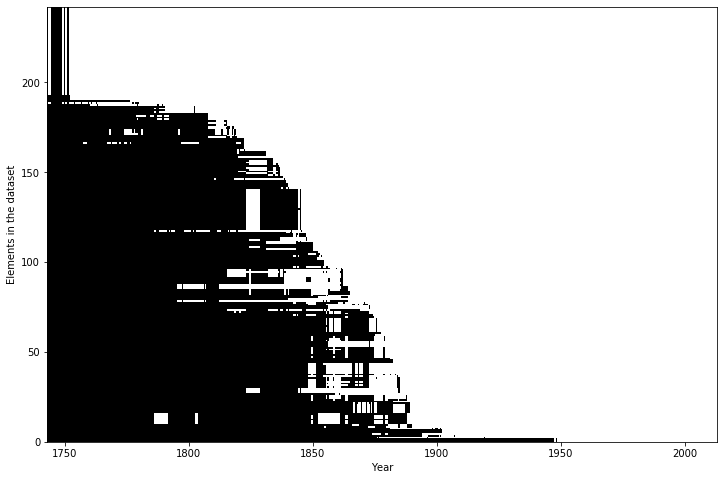

In [16]:
# Coverage:

show_availability(dfc, ['Date','Country','AverageTemperature'])

Conclusion: the situation here is worse, as for some countries we only have data from ~1950 (presumably because they didn't exist before, and they have no large citis?). So for any analysis we either do different starting points for different countries, or estimate it for the 1900-1950 (probably a bad idea, as it would require tracking geographical location of cities), or only work with the last 6 decades.

Let's check which countries are the most problematic:

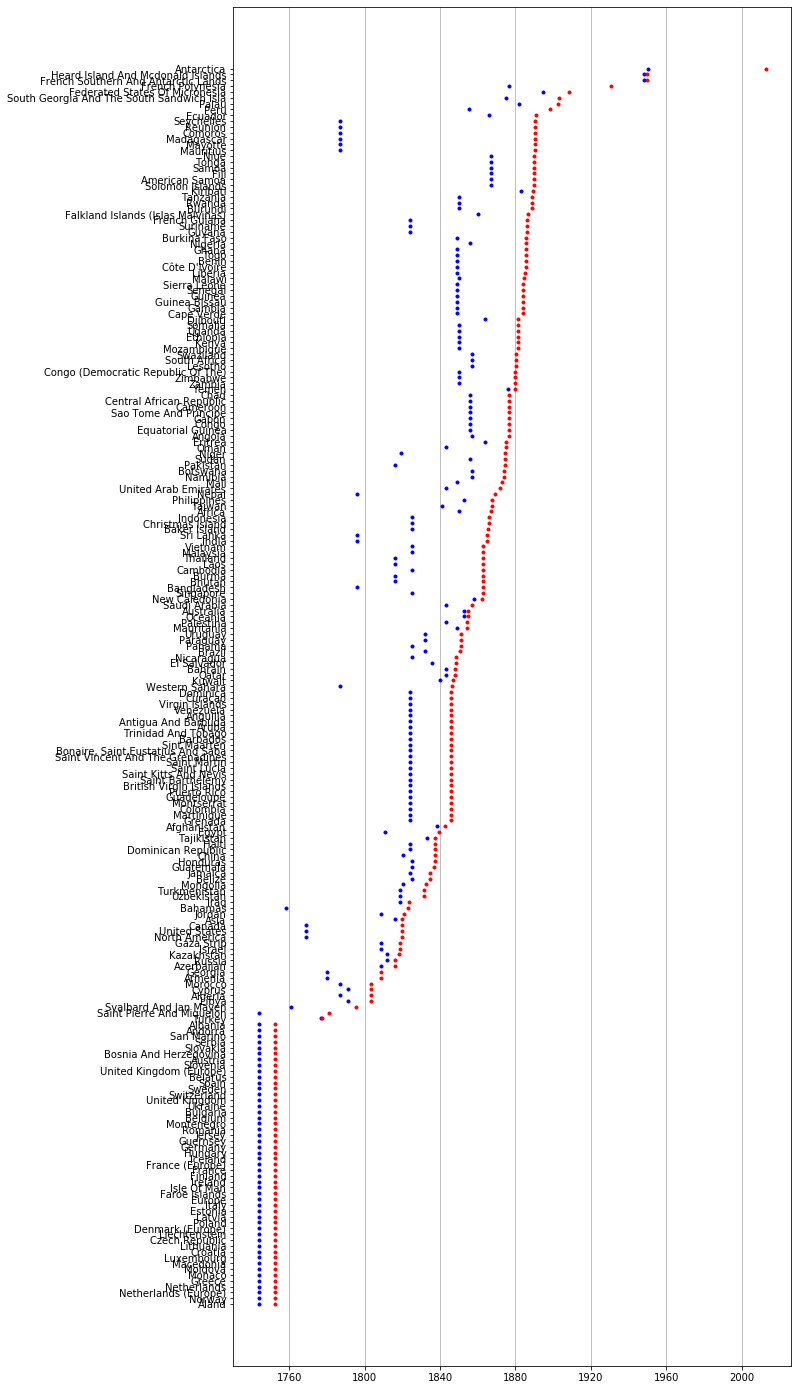

In [17]:
# Sorting countries by most recent missed data

dfc_missed = (dfc
              .query('Date.dt.year < 2013')
              .query("AverageTemperature.isna()", engine='python')
              .groupby('Country')
              .agg({'Date': 'max'})
              .reset_index()              
             )

# As a visual check, let's find the earliest record as well
dfc_earliest = (dfc                
                .groupby('Country')
                .agg({'Date': 'min'})
                .reset_index()
               )

dfc_recent = (dfc_missed
              .merge(dfc_earliest, on='Country', how='left', suffixes=['_lastnan', '_earliest'])              
             )
dfc_recent['Date'] = dfc_recent[['Date_lastnan', 'Date_earliest']].max(axis=1)
dfc_recent = dfc_recent.sort_values('Date')

plt.figure(figsize=(10,25))

plt.plot(dfc_recent.Date_earliest, dfc_recent.Country, 'b.');
plt.plot(dfc_recent.Date_lastnan, dfc_recent.Country, 'r.');
plt.grid(axis='x')

Conslusion: countries that started tracking very late are actually mostly island nations, and also Antarctica. Of 'large' countries the most 'at risk' on is Peru, but even it had its last NaN value before 1900, so 1900 seems to be a decent cut-off.

In [18]:
dfc_recent.query("Country == 'Peru'")

,Country,Date_lastnan,Date_earliest,Date
149,Peru,1898-03-01,1855-05-01,1898-03-01


In [19]:
# How many data points are missing after 1900?

df_missed = find_gaps(dfc, '1900-01-01', '2013-01-01').query("Country != 'Antarctica'")
print(f"Total missing data points: {df_missed.shape[0]}")
print(f"Countries with missing data: \n{df_missed.Country.unique()}")
print(f"Dates that were missed: \n{df_missed.dt.unique()}")

Total missing data points: 65
Countries with missing data: 
['Federated States Of Micronesia' 'French Polynesia'
 'French Southern And Antarctic Lands' 'Heard Island And Mcdonald Islands'
 'Palau' 'South Georgia And The South Sandwich Isla']
Dates that were missed: 
['1900-01-01' '1900-02-01' '1900-03-01' '1900-04-01' '1900-05-01'
 '1900-06-01' '1900-07-01' '1900-08-01' '1900-09-01' '1900-10-01'
 '1900-11-01' '1900-12-01' '1901-01-01' '1901-02-01' '1901-03-01'
 '1901-04-01' '1901-05-01' '1901-06-01' '1901-07-01' '1901-12-01'
 '1902-03-01' '1902-04-01' '1907-06-01' '1907-10-01' '1907-11-01'
 '1907-12-01' '1908-01-01' '1908-02-01' '1908-03-01' '1908-04-01'
 '1920-01-01' '1920-03-01' '1920-04-01' '1920-05-01' '1921-05-01'
 '1930-08-01' '1948-12-01' '1949-01-01' '1949-12-01' '1950-01-01'
 '1901-10-01' '1902-05-01' '1902-06-01' '1902-12-01']


Honestly, I'm tempted to just ignore this missing data. Most of it comes from very early 1900s, which is not that relevant, given that climate change accelerated in recent years. There are a few points in the 1940s, but only 5 total. Moreover, we need to find countries with largest changes in temperatures, and island nations will never be in this list. Ocean clamps temperature, so island nations would have more consistent temperatures, both at a month-to-month and year-to-year. If we were asked to find most stable countries, we would have had to worry about Palau, but for most extreme countries, we don't have to worry about Palau.

An alternative could be to use a predictive model to impute the data. Or, for single points, just take the average of neighboring months. Or look at the data point in the nearest year. Or only analyze the data after 1950.